# 🔹 Kurulum ve Başlangıç Ayarları

Bu bölümde eğitim için gerekli kütüphaneleri yükleyeceğiz ve Google Colab üzerinde
Drive bağlantısını yapacağız. Böylece verilerimize Drive üzerinden erişebileceğiz.  

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
import os
import cv2
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import zipfile
import shutil

# 🔹 Veri Seti Yükleme ve İnceleme

Bu bölümde veri setimizi Drive'dan okuyacağız.  
- `pandas` kullanarak tabloyu yükleyeceğiz.  
- İlk satırları görüntüleyip yapıyı kontrol edeceğiz.  
- Eksik değer var mı diye hızlıca inceleme yapacağız.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


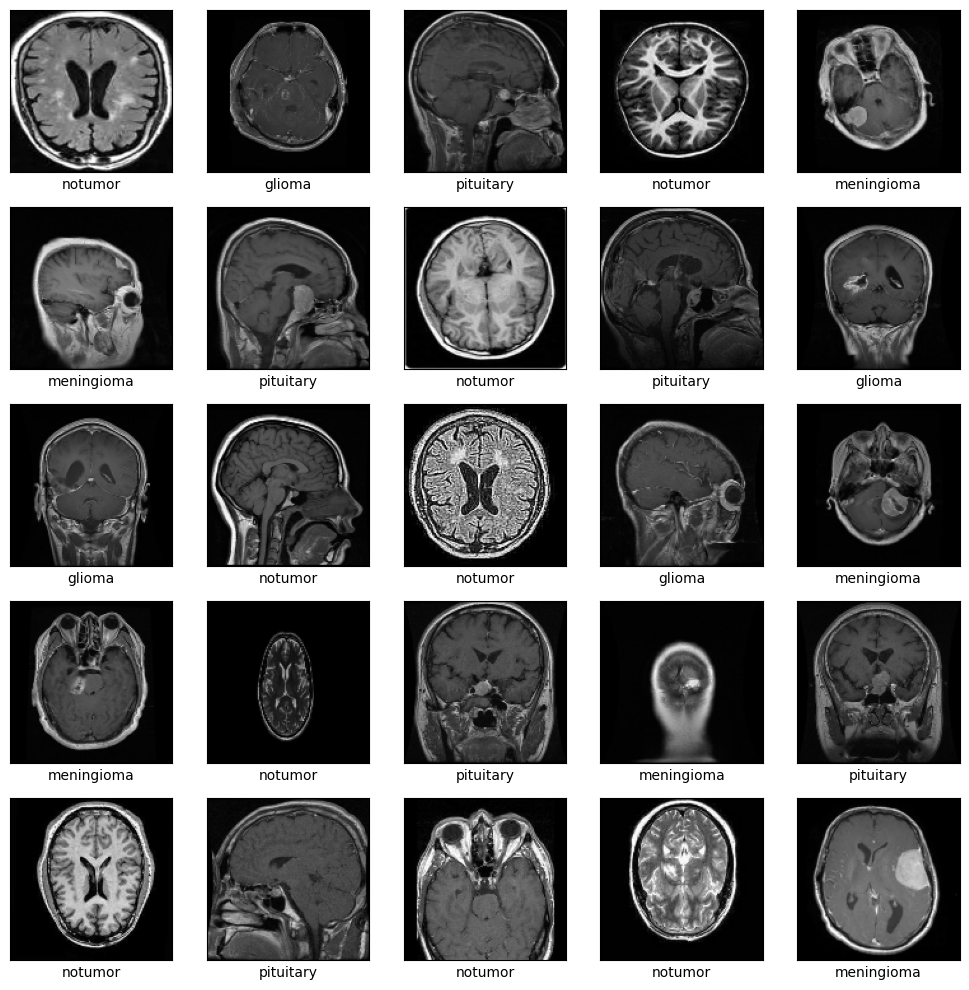

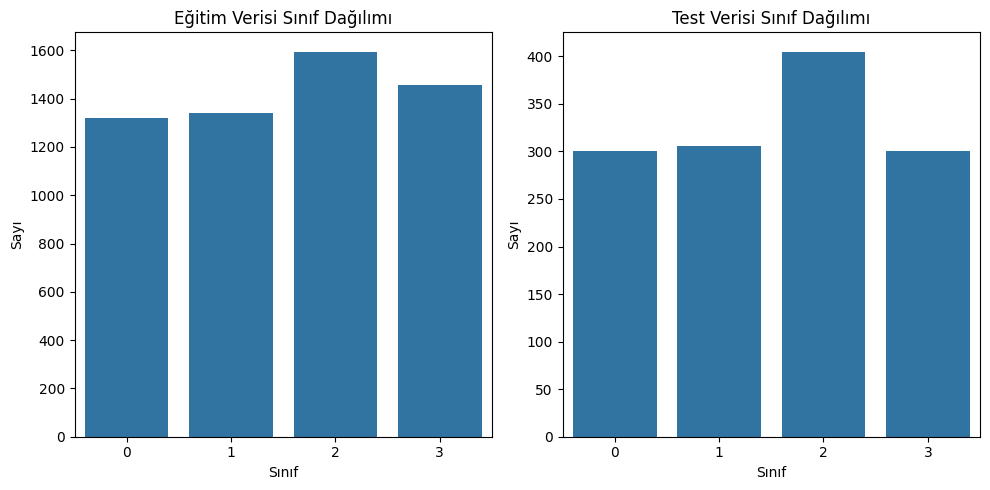

In [13]:
# Gerekli kütüphaneler
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drive'ı bağlama işlemi
drive.mount('/content/drive')

# Klasör yolları
train_dir = "/content/drive/MyDrive/kaggle/Training"
test_dir = "/content/drive/MyDrive/kaggle/Testing"

# Eğitim ve test veri setlerini yükle
train_ds_original = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)
test_ds_original = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

# Sınıf isimlerini kaydet
class_names = train_ds_original.class_names

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_original.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_original.map(lambda x, y: (normalization_layer(x), y))

# Performans için cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# İlk batch'ten 25 görseli görselleştirelim
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

plt.figure(figsize=(10, 10))
for i in range(min(25, len(images))):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(class_names[labels[i]])
plt.tight_layout()
plt.show()

# Sınıf dağılımını inceleyelim
all_labels = np.concatenate([y.numpy() for x, y in train_ds_original], axis=0)
all_test_labels = np.concatenate([y.numpy() for x, y in test_ds_original], axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=all_labels.flatten())
plt.title('Eğitim Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')

plt.subplot(1, 2, 2)
sns.countplot(x=all_test_labels.flatten())
plt.title('Test Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')
plt.tight_layout()
plt.show()


# 🔹 Veri Seti Hakkında Genel Bilgiler

Aşağıdaki kod ile:
- Sınıf isimlerini listeleyelim  
- Kaç örnek olduğunu sayalım  
- Görsellerden birkaç örnek görselleştirelim


In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

print("Eğitim sınıfları:", train_ds.class_names)
print("Eğitim batch sayısı:", len(train_ds))
print("Test batch sayısı:", len(test_ds))



Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Eğitim sınıfları: ['glioma', 'meningioma', 'notumor', 'pituitary']
Eğitim batch sayısı: 179
Test batch sayısı: 41


# 🔹 Veri Ön İşleme

Sinir ağları için görselleri normalize etmek (0–255 aralığından 0–1 aralığına) daha iyi sonuç verir.  
Bunun için `Rescaling` katmanını kullanacağız.  

Ayrıca:
- `cache()` → verileri belleğe alır, eğitim hızlanır.  
- `shuffle()` → verileri karıştırır.  
- `prefetch()` → GPU/CPU boş kalmadan veri hazırlanmasını sağlar.  


In [15]:
# Normalizasyon katmanı
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Eğitim verisine uygulama işlemi
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Performans için cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# 🔹 Kontrol: Görsellerin Normalize Edildiğini Görelim

Aşağıdaki kod ile normalize edilmiş bir batch'ten birkaç örnek görselleştirelim.


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


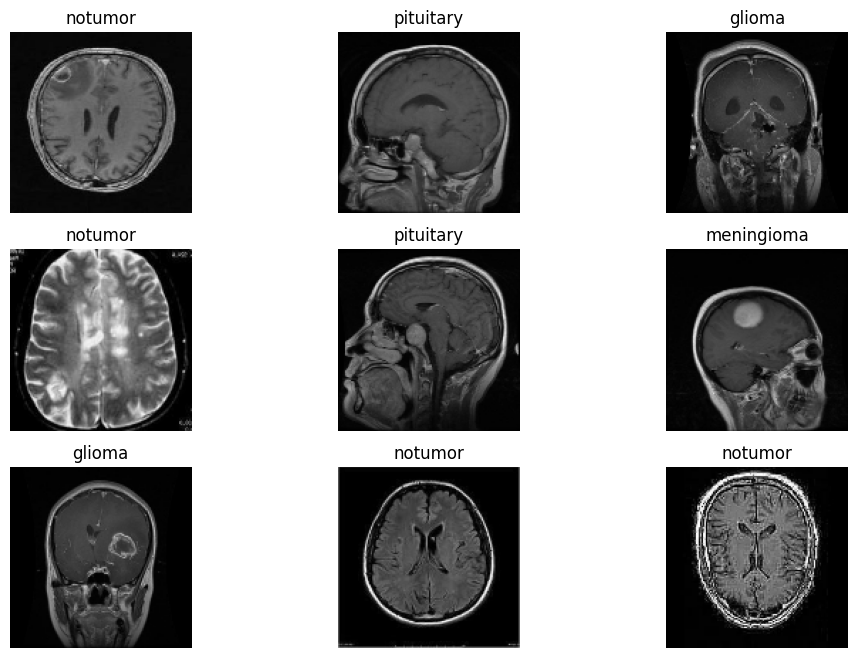

In [16]:
# Eğitim veri setini yükle ve sınıf isimlerini al
train_ds_original = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)
class_names = train_ds_original.class_names  # Sınıf isimlerini kaydetme işlemi

# Test veri setini yükle
test_ds_original = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_original.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_original.map(lambda x, y: (normalization_layer(x), y))

# Performans için cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize edilmiş görselleri kontrol
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()



🔹 Veri Artırma (Data Augmentation)

Veri artırma, eğitim veri setindeki görüntüleri rastgele dönüşümler uygulayarak çeşitlendirme işlemidir.  
Bu sayede model, farklı açılardan, boyutlardan veya ışık koşullarından gelen örnekleri görerek **daha iyi genelleme** yapabilir ve overfitting riski azalır.  

Yaygın veri artırma yöntemleri:
- Yatay çevirme (Horizontal Flip)
- Hafif dönme (Rotation)
- Yakınlaştırma/uzaklaştırma (Zoom)
- Kontrast değişimi (Contrast Adjustment)


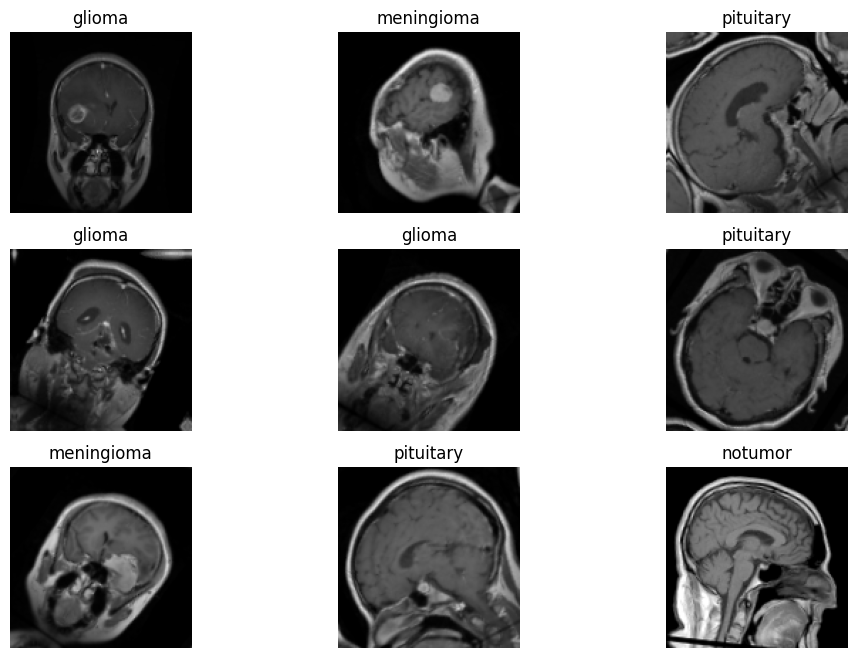

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma katmanı
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Yatay çevirme
    layers.RandomRotation(0.1),               # Hafif dönme
    layers.RandomZoom(0.1),                   # Zoom
    layers.RandomContrast(0.1)                # Kontrast değişimi
])

# Örnek: ilk batch'e uygulayalım ve görselleştirelim
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))  # Batch boyutu ekle
        plt.imshow(augmented_image[0].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()


🔹CNN Model Açıklaması

- **Data Augmentation:** Görselleri rastgele döndürme, çevirme, zoom ve kontrast değişimi ile çeşitlendirir.  
- **Conv2D + MaxPooling2D:** Özellik çıkarımı ve boyut küçültme.  
- **BatchNormalization:** Eğitim hızını artırır ve stabilite sağlar.  
- **Dropout:** Aşırı öğrenmeyi önler.  
- **Flatten + Dense:** Özellikleri sınıflandırmaya dönüştürür.  
- **Optimizer & Loss:** Adam optimizasyonu + sparse categorical crossentropy.  
- **Output:** Softmax ile sınıf olasılıkları.

In [18]:
# train_ds'den resim boyutlarını alma
for images, labels in train_ds.take(1):
    img_height, img_width = images.shape[1], images.shape[2]

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)


In [19]:
from tensorflow.keras import layers, models, Input

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        Input(shape=input_shape),  # İlk katmanda input_shape tanımlıyoruz
        data_augmentation,          # Veri artırma katmanı

        # 1. Convolution bloğu
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # 2. Convolution bloğu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # 3. Convolution bloğu
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Örnek kullanım
img_height = 128
img_width = 128
num_classes = len(class_names)

model = create_cnn_model((img_height, img_width, 3), num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,483,364 (17.10 MB)

 Trainable params: 4,482,660 (17.10 MB)

 Non-trainable params: 704 (2.75 KB)

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

# Eğitim ve doğrulama veri setlerini ayırma
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Test veri seti
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


🔹CNN Model Eğitimi
Oluşturulan CNN modeli `train_ds` verisi ile eğitiliyor ve `val_ds` doğrulama verisi ile performans izleniyor.


In [21]:
epochs = 16

history = model.fit(
    train_ds,         # eğitim veri seti
    validation_data=val_ds,  # doğrulama veri seti
    epochs=epochs
)


Epoch 1/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.6242 - loss: 1.0267 - val_accuracy: 0.2566 - val_loss: 4.0924
Epoch 2/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7400 - loss: 0.6815 - val_accuracy: 0.4667 - val_loss: 1.1326
Epoch 3/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7806 - loss: 0.5891 - val_accuracy: 0.5000 - val_loss: 1.4037
Epoch 4/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7999 - loss: 0.5232 - val_accuracy: 0.7434 - val_loss: 0.6432
Epoch 5/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8387 - loss: 0.4435 - val_accuracy: 0.5604 - val_loss: 1.4026
Epoch 6/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8650 - loss: 0.3865 - val_accuracy: 0.7548 - val_loss: 0.6730
Epoch 7/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8735 - loss: 0.3630 - val_accuracy: 0.6751 - val_loss: 0.9898
Epoch 8/16
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8881 - loss: 0.3130 -

Model Doğruluğu ve Kayıp Grafiği

Model eğitildikten sonra eğitim ve doğrulama doğruluğunu, ayrıca kayıp değerlerini görselleştirmek için kullanılan grafikler:

Sol grafikte: Eğitim ve doğrulama doğruluğu

Sağ grafikte: Eğitim ve doğrulama kaybı

Bu görselleştirme, modelin aşırı öğrenme (overfitting) yapıp yapmadığını ve genel performansını hızlıca değerlendirmeye yardımcı olur.

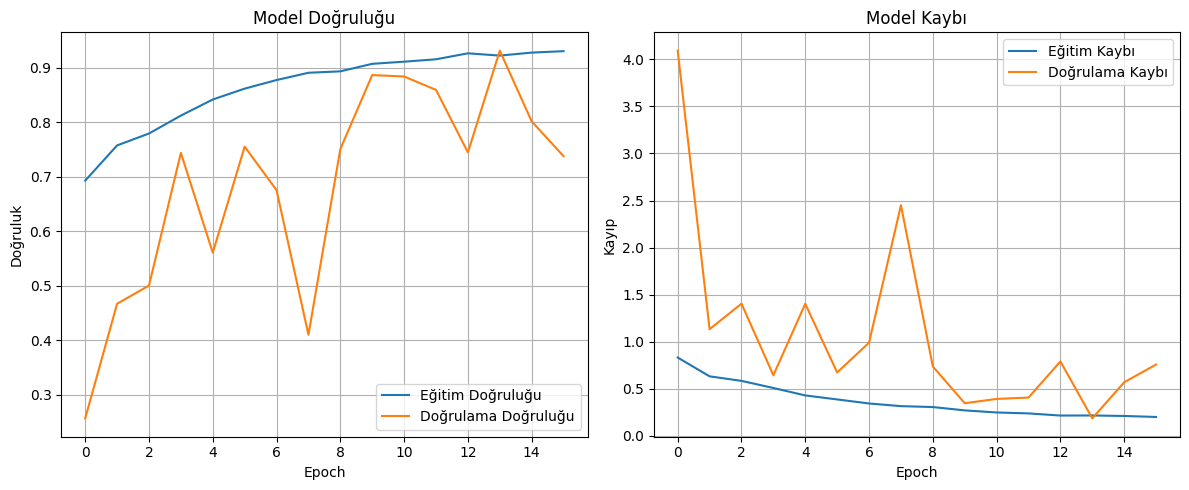

In [23]:
import matplotlib.pyplot as plt
# Örnek: history = model.fit(train_ds, validation_data=val_ds, epochs=20)

# Doğruluk grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Model Değerlendirme Aşaması

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.7580 - loss: 0.7656
Test Kaybı: 0.7551
Test Doğruluğu: 0.7536
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      glioma       0.60      0.99      0.75       300
  meningioma       0.83      0.21      0.34       306
     notumor       0.80      0.98      0.88       405
   pituitary       0.95      0.76      0.84       300

    accuracy                           0.75      1311
   macro avg       0.80      0.74      0.70      1311
weighted avg       0.80      0.75      0.72      1311



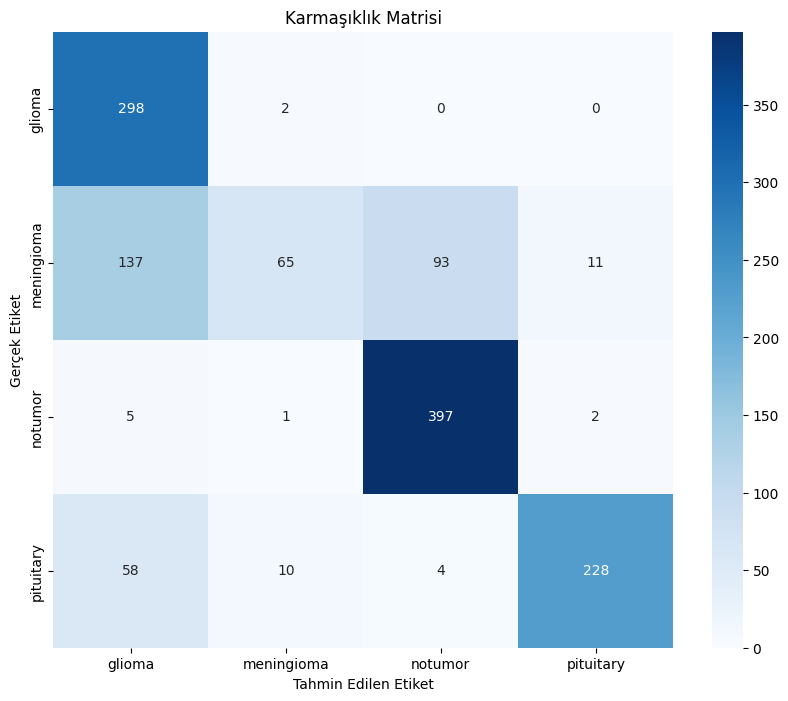

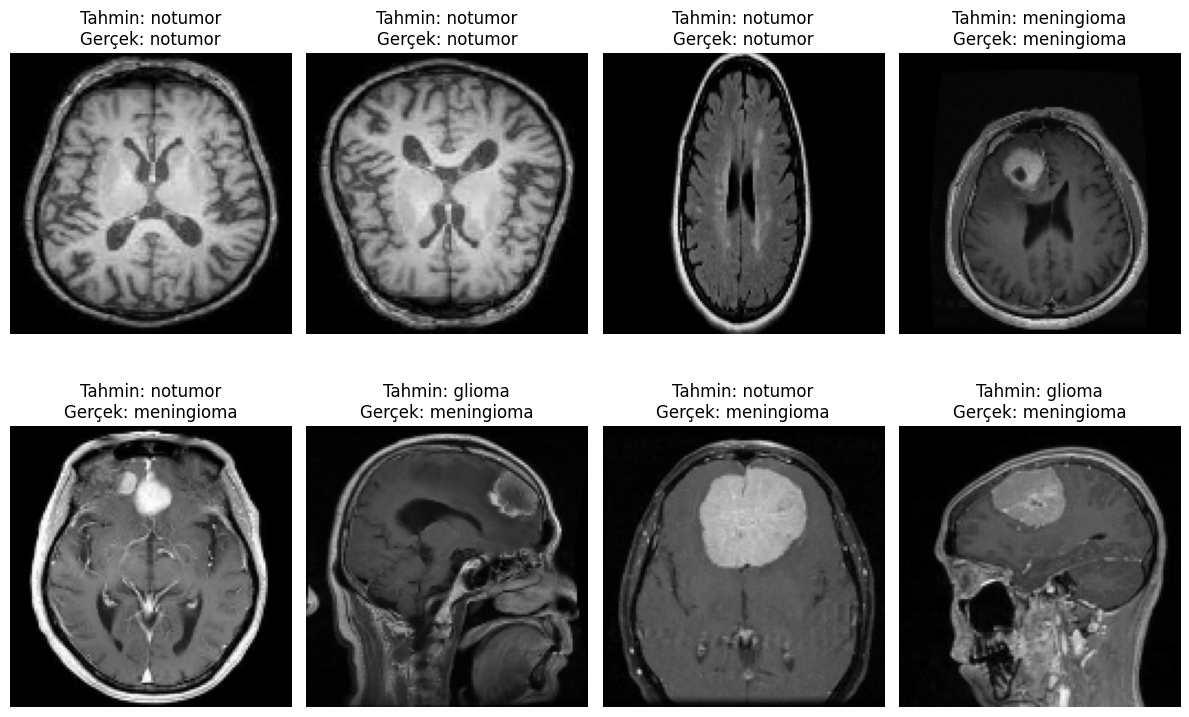

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Test veri seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

# Tahminlerde bulunalım
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketleri alalım
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.array(list(test_ds.unbatch().map(lambda x, y: x))[correct]))
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGerçek: {class_names[y_true[correct]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(np.array(list(test_ds.unbatch().map(lambda x, y: x))[incorrect]))
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGerçek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
Önceden Eğitilmiş Hazır Bir Modelle Eğitim

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

# Önceden eğitilmiş VGG16 modelini kullanalım
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)  # senin veri boyutuna göre
)

# Temel modelin katmanlarını donduralım
for layer in base_model.layers:
    layer.trainable = False

# Yeni bir model oluşturalım
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # sınıf sayısı senin veri setine göre
])

# Modeli derleyelim
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

# Modeli eğitelim
history_transfer = transfer_model.fit(
    train_ds,          # eğitim veri seti
    validation_data=test_ds,  # test/validation veri seti
    epochs=20,
    verbose=1
)

# Transfer learning modelini değerlendirelim
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_ds, verbose=1)
print(f"Transfer Learning Test Doğruluğu: {test_accuracy_transfer:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 157ms/step - accuracy: 0.5656 - loss: 1.0142 - val_accuracy: 0.7811 - val_loss: 0.6372
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8018 - loss: 0.5477 - val_accuracy: 0.8055 - val_loss: 0.5693
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.8440 - loss: 0.4336 - val_accuracy: 0.8207 - val_loss: 0.4939
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8658 - loss: 0.3843 - val_accuracy: 0.8200 - val_loss: 0.4851
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8545 - loss: 0.3881 - val_accuracy: 0.8330 - val_loss: 0.4324
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8629 - loss: 0.3687 - val_accuracy: 0.8528 - val_loss: 0.4225
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8748 - loss: 0.3257 - val_accuracy: 0.8383 - val_loss: 0.4096
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8733 - loss: 0.3422 -

Modellerin Karşılaştırılması

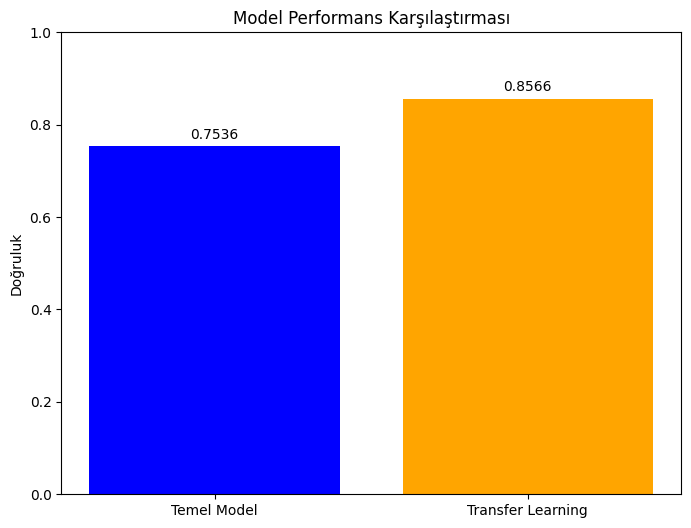

In [38]:
import matplotlib.pyplot as plt

# Model performanslarını karşılaştıralım
models = ['Temel Model', 'Transfer Learning']
accuracies = [test_accuracy, test_accuracy_transfer]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

# Çubukların üzerine doğruluk değerlerini yazalım
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()


Model İyileştirme Teknikleri


Adam optimizer ile eğitim...
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5495 - loss: 1.0500 - val_accuracy: 0.7307 - val_loss: 0.7015
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7983 - loss: 0.5523 - val_accuracy: 0.7963 - val_loss: 0.5821
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8291 - loss: 0.4690 - val_accuracy: 0.8192 - val_loss: 0.5111
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8417 - loss: 0.4178 - val_accuracy: 0.8085 - val_loss: 0.4920
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8481 - loss: 0.3907 - val_accuracy: 0.8314 - val_loss: 0.4458
Adam Test Doğruluğu: 0.8314

RMSprop optimizer ile eğitim...
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5642 - loss: 1.0492 - val_accuracy: 0.7567 - val_loss: 0.6702
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7828 - loss: 0.5835 - val_accuracy: 0.7735 - val_loss: 0.5960
Epoch 

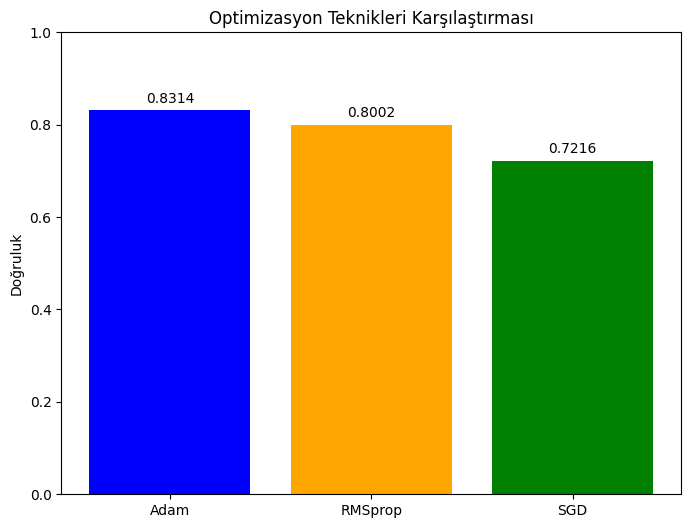

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

# Optimizasyon teknikleri
optimizers = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{opt_name} optimizer ile eğitim...")

    # Transfer learning modeli oluştur
    base_model = keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    base_model.trainable = False

    transfer_model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    transfer_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Modeli eğit
    history = transfer_model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=5,
        verbose=1
    )

    # Test doğruluğu
    test_loss, test_acc = transfer_model.evaluate(test_ds, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f}")

# Optimizasyon tekniklerini karşılaştıralım
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.title('Optimizasyon Teknikleri Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()


Modelin Son Değerlendirmesi

In [41]:
print("=" * 50)
print("Brain Tumor MRI Sonuçları")
print("=" * 50)
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")  # temel modelden gelen doğruluk
print(f"Transfer Learning Model Doğruluğu: {test_accuracy_transfer:.4f}")  # transfer learning doğruluk
best_optimizer = max(results, key=results.get)
best_acc = results[best_optimizer]
print(f"En iyi optimizer: {best_optimizer} ({best_acc:.4f})")  # optimizasyon karşılaştırması
print("=" * 50)


Brain Tumor MRI Sonuçları
Temel CNN Model Doğruluğu: 0.7536
Transfer Learning Model Doğruluğu: 0.8566
En iyi optimizer: Adam (0.8314)
